# Hit or flop movie prediction
The goal of the project is to create a classification model that predicts whether a movie will be a commercial success ("hit") or a failure ("flop") based on attributes from movie metadata. This problem is formulated as a binary classification problem.

The `movies_metadata.csv` dataset comes from the Kaggle platform and contains various information about movies such as budget (`budget`), revenue (`revenue`), popularity (`popularity`), movie length (`runtime`) and other attributes.

We use the ratio of revenue to budget to define the success of a film (`success'). A film is labeled as:
- **Hit (1)** if `revenue > 2 * budget`
- **Flop (0)** if `revenue <= 2 * budget`

This method of categorization reflects a simplistic economic view where a film must bring in at least twice the budget to cover production and marketing costs and be considered commercially successful.

## Data loading and preprocessing
Load the `movies_metadata.csv` file, converting the key numeric columns `budget` and `revenue` to float type. These columns are often stored as strings, sometimes with missing values, so we remove records where `budget` or `revenue` is 0. These values are not useful for determining the success rate of a movie.

low_memory=False ensures that Pandas does not read data in chunks (may consume more memory, but avoids problems with mixed data types).

errors="coerce" means that invalid values (e.g. text or empty cells) are converted to NaN (Not a Number).

We only keep movies that have positive budget and revenue (i.e., remove entries with NaN or values ≤ 0).

In [53]:
import pandas as pd

df = pd.read_csv("movies_metadata.csv", low_memory=False)

df["budget"] = pd.to_numeric(df["budget"], errors="coerce")
df["revenue"] = pd.to_numeric(df["revenue"], errors="coerce")

df = df[(df["budget"] > 0) & (df["revenue"] > 0)]

### Visualization of budget and revenue distribution
This code creates a histogram (a height bar chart of the data distribution) for the budget and revenue columns of the DataFrame df using the Seaborn and Matplotlib libraries. The histograms show a strong rightward skew of the `budget` and `revenue` values, which is common in economic data. The logarithmic transformation helps to show these differences better.

If we turn off the logarithmic view, the graph will be "glued" to the left axis with a long tail to the right.



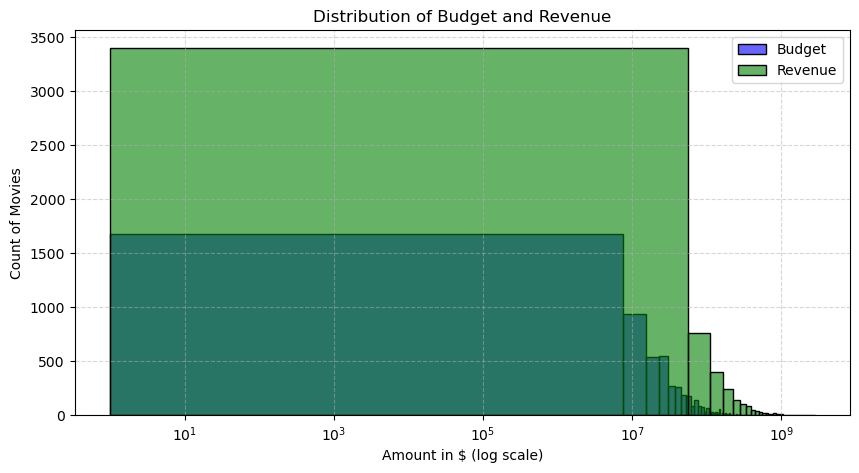

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5)) # Chart size: width 10, height 5
sns.histplot(df["budget"], bins=50, color="blue", alpha=0.6, label="Budget") #Data is split into 50 intervals (columns), alpha=0.6: Color transparency (for overlapping data)
sns.histplot(df["revenue"], bins=50, color="green", alpha=0.6, label="Revenue") #same as above, but for revenue
plt.xscale("log") # Logarithmic scale on X-axis (for better display of large ranges of values)
plt.xlabel("Amount in $ (log scale)") #label
plt.ylabel("Count of Movies") #label
plt.title("Distribution of Budget and Revenue") # Chart name
plt.grid(True, linestyle="--", alpha=0.5) #přidal jsem čtvercovou mřížku pro lepší čitelnost
plt.legend() # Legend view (Budget vs. Revenue)
plt.show() #show chart

### Creating the target variable `success`

We define a binary variable `success`, where:
- 1 (hit): the yield is more than twice the budget
- 0 (flop): the return is less than or equal to twice the budget

This condition simulates the reality of the movie industry, where movies normally need to exceed 2x the budget to make a profit.

This code creates a new `success` column in the DataFrame df that indicates whether the film was financially successful according to a  criteria.

In [55]:
df["success"] = df["revenue"] > (2 * df["budget"]) #compares whether the film's revenue is at least twice the budget
df["success"] = df["success"].astype(int) #converts True to 1 and False to 0 (binary integer values)

### Input attributes selection and data cleaning

We have selected the relevant attributes for modelling:
- `budget`, `popularity`, `runtime`, `vote_average`, `vote_count`.

This code prepares data for further analysis or machine learning by selecting specific columns (features) and removing rows with missing values.
We get rid of unnecessary columns that will not be used in the analysis.
Removing NaN values improves data quality.

In [56]:
features = ["budget", "popularity", "runtime", "vote_count", "vote_average"]
df = df[features + ["success"]].dropna()  #from the original df only the columns listed in features and the "success" column are selected
#dropna() removes rows with missing values

### Correlation analysis

Using a heatmap, we observe the relationships between each attribute and the target variable. This helps us in selecting attributes for modeling and possibly removing multicollinearity.

Identifying redundant variables: if 2 features are strongly correlated, maybe we just use one. Models tend to benefit from uncorrelated inputs. This chart is key for exploratory data analysis (EDA) before modelling.

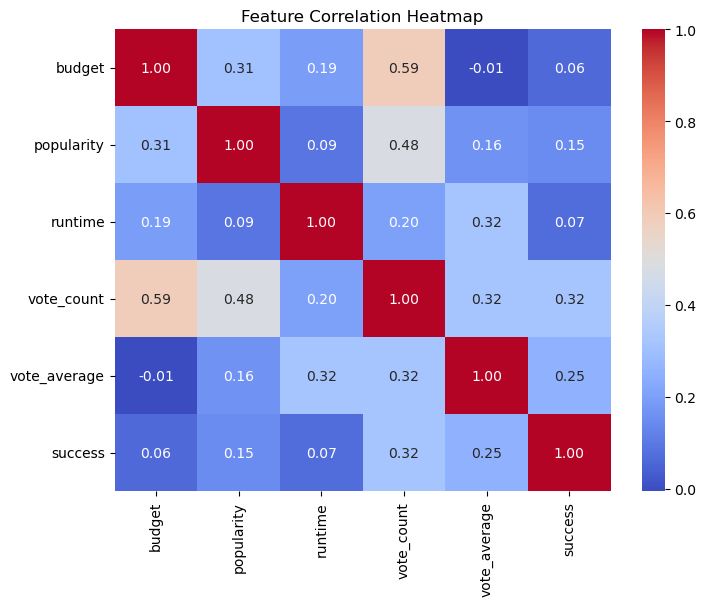

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6)) # Setting the chart size
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
#correlation matrix, displays values in cells, color scale (blue = -1, red = +1), format values to 2 decimal places
plt.title("Feature Correlation Heatmap")
plt.show()

### Standardization of numeric attributes

We use `StandardScaler` from scikit-learn to standardize numeric attributes. This is important preprocessing for algorithms that are sensitive to the scale of the input data.

StandardScaler transforms each value in those columns according to the formula: z = (x - μ) / σ,
<p> where μ is the average of the column values and σ is the standard deviation.
<p>It results in values with a mean of 0 and a standard deviation of 1 ("Z-score").
<p>Only the specified columns (numeric features) are transformed, the target column (success) remains unchanged.

In [58]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df[["budget", "popularity", "runtime", "vote_count", "vote_average"]] = scaler.fit_transform(
    df[["budget", "popularity", "runtime", "vote_count", "vote_average"]]
)

## Model training: random forest + hyperparameter tuning

We divide the dataset into training and testing parts (80:20 ratio). Using `GridSearchCV` we tune the hyperparameters of the `RandomForestClassifier` model:
- `n_estimators`: number of trees
- `max_depth`: maximum tree depth
- `min_samples_split`: minimum number of samples for node splitting

We train the model on the training data and evaluate it using accuracy (`accuracy`) on the test data. Grid Search tests all combinations of hyperparameters from `param_grid`.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV

X = df[features] # Input variables (features)
y = df["success"] # Target variable (0/1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) #80% training set, 20% test set (test_size=0.2)

#Grid Search settings for hyperparameter tuning, smaller amount of parameters for faster execution
param_grid = {
    'n_estimators': [100, 200], # Number of decision trees
    'max_depth': [None, 10, 20], # Maximum tree depth
    'min_samples_split': [2, 5], # Minimum number of samples for node splitting
}

grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=5, # 5-times cross-validation
    scoring='accuracy') # Metrics for choosing the best model
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
model = grid_search.best_estimator_ # Best model from grid search

y_pred = model.predict(X_test) #prediction for test set


print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
#ladění hyper parametrů pomocí gridsearchCV napr 100 stromů není správně ROC křivka
#přidat popisky v MD 

from sklearn.metrics import roc_auc_score
y_proba = model.predict_proba(X_test)[:, 1] 
print("ROC-AUC:", roc_auc_score(y_test, y_proba)) 
#nevím, jestli tam máme přidat i tuhle ROC křivku

Best Parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}
Accuracy: 0.6942379182156134
              precision    recall  f1-score   support

           0       0.67      0.72      0.69       522
           1       0.72      0.67      0.69       554

    accuracy                           0.69      1076
   macro avg       0.69      0.69      0.69      1076
weighted avg       0.70      0.69      0.69      1076

ROC-AUC: 0.7864088413073849


### Evaluation of the random forest model: Confusion Matrix

Confusion matrix provides a more detailed insight into how the model classifies each class (true positives, false negatives, etc.).

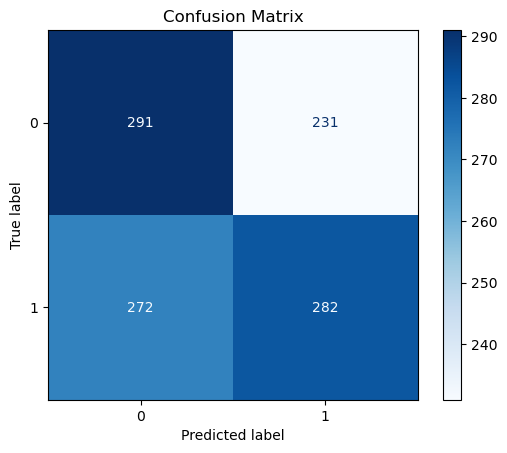


Performance per actual class:
- Successful films: 50.9% correctly predicted, 49.1% missed
- Unsuccessful films: 55.7% correctly predicted, 44.3% false alarms


In [69]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# Calculate percentage of correct predictions

row_totals = cm.sum(axis=1)
cm_percent_rows = cm / row_totals[:, np.newaxis] * 100

print(f"\nPerformance per actual class:")
print(f"- Successful films: {cm_percent_rows[1,1]:.1f}% correctly predicted, {cm_percent_rows[1,0]:.1f}% missed")
print(f"- Unsuccessful films: {cm_percent_rows[0,0]:.1f}% correctly predicted, {cm_percent_rows[0,1]:.1f}% false alarms")

## xgboost

In [77]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Model
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}

grid_xgb = GridSearchCV(estimator=xgb,
                        param_grid=param_grid,
                        cv=5,
                        scoring='accuracy',
                        verbose=1,
                        n_jobs=-1)

# training
grid_xgb.fit(X_train, y_train)

# output best parameters and score
print("Best parameters:", grid_xgb.best_params_)
print("Best score (CV accuracy):", grid_xgb.best_score_)

# prediction
y_pred = grid_xgb.predict(X_test)

# evaluate
print("Test Accuracy:", grid_xgb.score(X_test, y_test))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# AUC score
y_proba = grid_xgb.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, y_proba)
print("AUC:", auc_score)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [01:44:34] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1738880277541/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [01:44:34] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1738880277541/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [01:44:34] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1738880277541/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [01:44:34] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1738880277541/work/src/learner.cc:

Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1}
Best score (CV accuracy): 0.5662199173486753
Test Accuracy: 0.5566914498141264
[[327 195]
 [282 272]]
              precision    recall  f1-score   support

           0       0.54      0.63      0.58       522
           1       0.58      0.49      0.53       554

    accuracy                           0.56      1076
   macro avg       0.56      0.56      0.56      1076
weighted avg       0.56      0.56      0.55      1076

AUC: 0.5846058619306473


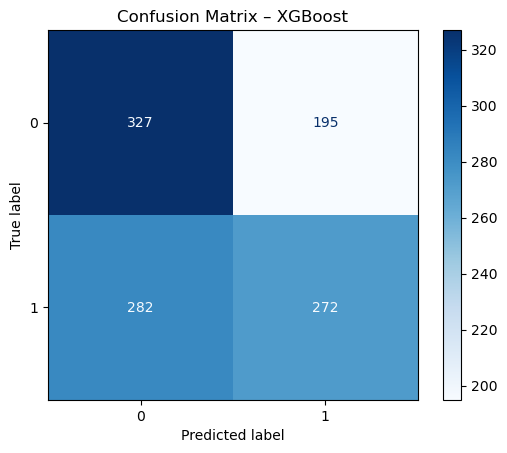


🔍 Performance per actual class (XGBoost):
- Successful films: 49.1% correctly predicted, 50.9% missed
- Unsuccessful films: 62.6% correctly predicted, 37.4% false alarms


In [78]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Predict
y_pred_xgb = grid_xgb.predict(X_test)

# Confusion matrix
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
disp_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_xgb)
disp_xgb.plot(cmap="Blues")
plt.title("Confusion Matrix – XGBoost")
plt.show()

# Procentuální vyhodnocení
row_totals = cm_xgb.sum(axis=1)
cm_percent_rows = cm_xgb / row_totals[:, np.newaxis] * 100

print(f"\n🔍 Performance per actual class (XGBoost):")
print(f"- Successful films: {cm_percent_rows[1,1]:.1f}% correctly predicted, {cm_percent_rows[1,0]:.1f}% missed")
print(f"- Unsuccessful films: {cm_percent_rows[0,0]:.1f}% correctly predicted, {cm_percent_rows[0,1]:.1f}% false alarms")

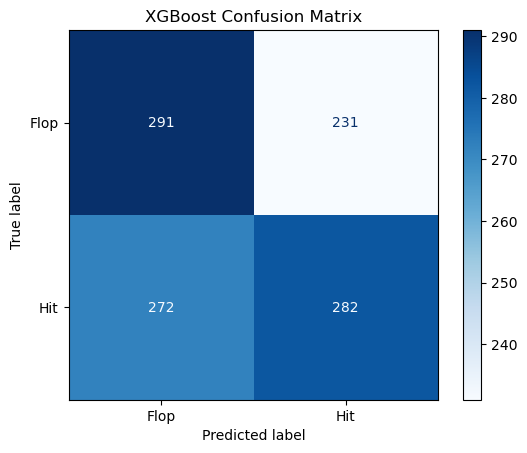

              precision    recall  f1-score   support

        Flop       0.52      0.56      0.54       522
         Hit       0.55      0.51      0.53       554

    accuracy                           0.53      1076
   macro avg       0.53      0.53      0.53      1076
weighted avg       0.53      0.53      0.53      1076



In [63]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import xgboost as xgb

df = pd.read_csv("movies_metadata.csv", low_memory=False)

df['budget'] = pd.to_numeric(df['budget'], errors='coerce')
df['revenue'] = pd.to_numeric(df['revenue'], errors='coerce')

df = df.dropna(subset=['budget', 'revenue'])
df = df[(df['budget'] > 0) & (df['revenue'] > 0)]

df['hit'] = (df['revenue'] > 2 * df['budget']).astype(int)

df['runtime'] = pd.to_numeric(df['runtime'], errors='coerce')
df = df.dropna(subset=['runtime'])
features = ['budget', 'runtime']
X = df[features]
y = df['hit']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = xgb.XGBClassifier( eval_metric='logloss')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Flop", "Hit"])
disp.plot(cmap="Blues")
plt.title("XGBoost Confusion Matrix")
plt.show()

print(classification_report(y_test, y_pred, target_names=["Flop", "Hit"]))